### Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [1]:
import os
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torch.autograd import Variable

In [2]:
mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:01<00:00, 15964956.05it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 310594.48it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5489738.09it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13770584.82it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

As expected, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


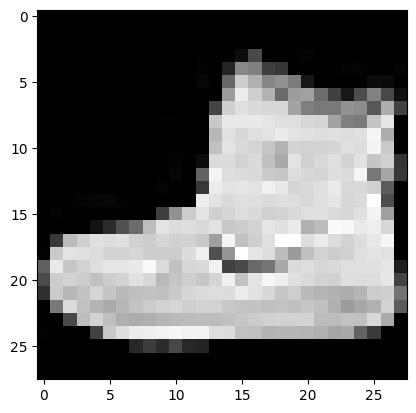

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Finally, let's create a dataloader to load the images in batches.

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([2, 8, 1, 6, 3, 5, 0, 2, 0, 8, 5, 6, 9, 2, 1, 0, 9, 2, 2, 8, 6, 2, 7, 9,
        1, 6, 2, 3, 6, 8, 3, 9, 7, 6, 8, 4, 4, 3, 5, 1, 8, 3, 0, 6, 5, 3, 9, 3,
        5, 6, 6, 0, 8, 0, 7, 2, 9, 5, 4, 5, 0, 8, 4, 1, 4, 0, 6, 8, 8, 5, 9, 9,
        7, 4, 7, 2, 0, 1, 9, 5, 3, 8, 5, 9, 0, 3, 0, 1, 1, 8, 7, 5, 1, 0, 0, 1,
        1, 4, 1, 3])


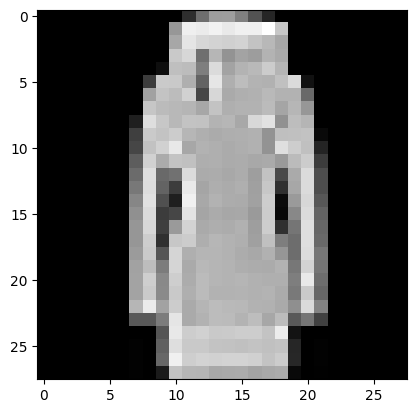

In [7]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

We'll also create a `device` which can be used to move the data and models to a GPU, if one is available.

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

#### Discriminator Network

In [10]:
image_size = 784
hidden_size = 256

In [11]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [12]:
D.to(device);

#### Generator Network

In [13]:
latent_size = 64

In [14]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [15]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

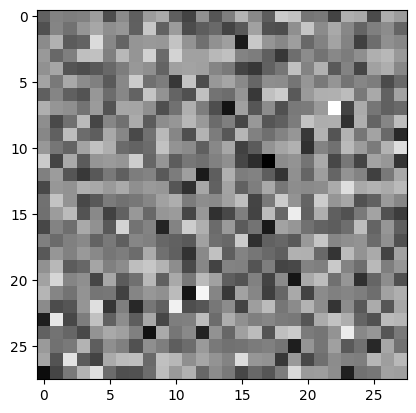

In [16]:
plt.imshow(gen_imgs[0], cmap='gray');

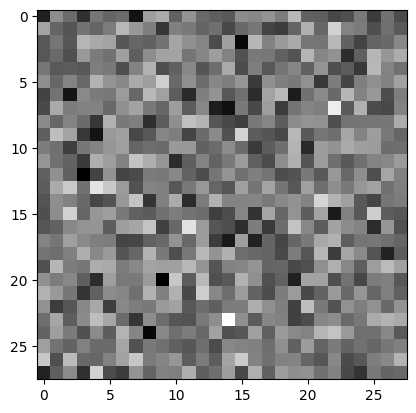

In [17]:
plt.imshow(gen_imgs[1], cmap='gray');

As one might expect, the output from the generator is basically random noise. Let's define a helper function which can save a batch of outputs from the generator to a file.

Let's move the generator to the chosen device.

In [18]:
G.to(device);

#### Discriminator Training

In [19]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

Let's define helper functions to reset gradients and  train the discriminator.

In [20]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the MSE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

#### Generator Training

In [21]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [22]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

### Step2. Train the GAN model to produce images in this new domain.

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model

In [23]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Let's save a batch of real images that we can use for visual comparision while looking at the generated images.

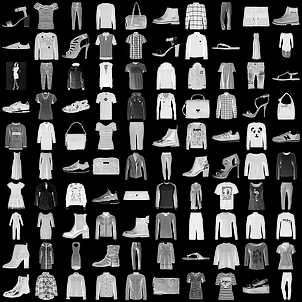

In [24]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


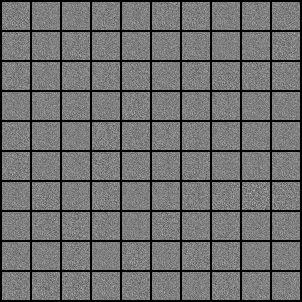

In [25]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator. The training might take a while if you're not using a GPU.

In [26]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0141, g_loss: 0.8631, D(x): 0.98, D(G(z)): 0.11
Epoch [0/300], Step [400/600], d_loss: 0.0045, g_loss: 0.9728, D(x): 0.98, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.0183, g_loss: 0.9560, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0060, g_loss: 0.9825, D(x): 0.99, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.0080, g_loss: 0.9881, D(x): 0.98, D(G(z)): 0.01
Epoch [1/300], Step [600/600], d_loss: 0.0028, g_loss: 0.9638, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0039, g_loss: 0.9511, D(x): 0.99, D(G(z)): 0.03
Epoch [2/300], Step [400/600], d_loss: 0.0029, g_loss: 0.9711, D(x): 0.99, D(G(z)): 0.02
Epoch [2/300], Step [600/600], d_loss: 0.0096, g_loss: 0.9487, D(x): 0.99, D(G(z)): 0.04
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0589, g_loss: 0.9814, D(x): 0.92, D(G(z)): 0.01
Epoch [3/300], Step [400/6

### Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

Here's how the generated images look, after the 10th, 50th and 300th epochs of training.

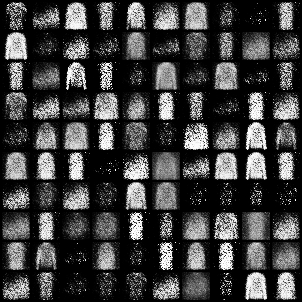

In [27]:
Image('./samples/fake_images-0010.png')

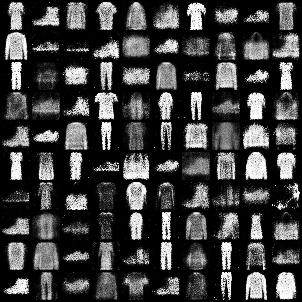

In [28]:
Image('./samples/fake_images-0050.png')

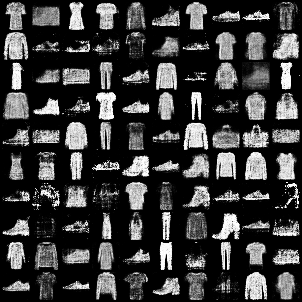

In [29]:
Image('./samples/fake_images-0300.png')

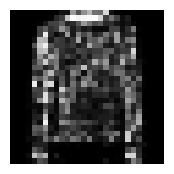

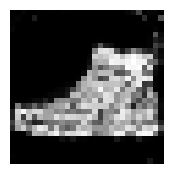

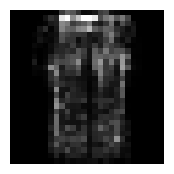

In [30]:
save_dir = 'generated_data/'
num_imgs = 3

os.makedirs(save_dir, exist_ok=True)

y = torch.randn(num_imgs, latent_size).to(device)
fake_images_new = G(y)
gen_imgs = denorm(fake_images_new.reshape((-1, 28,28)).detach())

for i in range(num_imgs):
    image_cpu = gen_imgs[i].cpu().numpy()
    plt.figure(figsize=(2, 2))
    plt.imshow(image_cpu, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.savefig(f'{save_dir}/generated_image_{i+1}.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()

We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

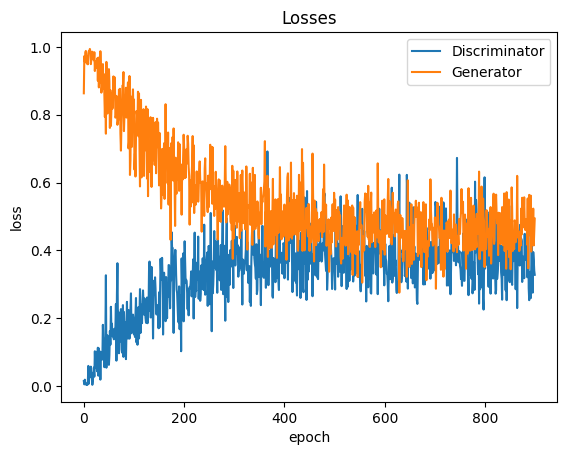

In [31]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

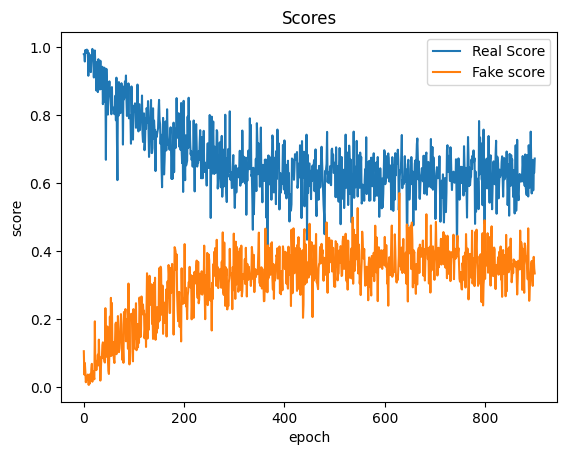

In [32]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### Step4. Save the model weights in the folder to be used later.

In [33]:
# Save the model weights
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

### Step5. Load the model using the saved weights.

In [34]:
G.load_state_dict(torch.load('G.ckpt'))
D.load_state_dict(torch.load('D.ckpt'))

<All keys matched successfully>

### Step 6: Re-train the GAN model to see if you can improve.

In [35]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the MSE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [36]:
%%time

num_epochs_retrain = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs, num_epochs+num_epochs_retrain):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs+num_epochs_retrain, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [300/600], Step [200/600], d_loss: 0.3715, g_loss: 0.4604, D(x): 0.62, D(G(z)): 0.37
Epoch [300/600], Step [400/600], d_loss: 0.3542, g_loss: 0.5324, D(x): 0.65, D(G(z)): 0.38
Epoch [300/600], Step [600/600], d_loss: 0.2444, g_loss: 0.5227, D(x): 0.70, D(G(z)): 0.25
Saving fake_images-0301.png
Epoch [301/600], Step [200/600], d_loss: 0.2728, g_loss: 0.5308, D(x): 0.69, D(G(z)): 0.28
Epoch [301/600], Step [400/600], d_loss: 0.4040, g_loss: 0.4739, D(x): 0.60, D(G(z)): 0.37
Epoch [301/600], Step [600/600], d_loss: 0.3837, g_loss: 0.4841, D(x): 0.57, D(G(z)): 0.32
Saving fake_images-0302.png
Epoch [302/600], Step [200/600], d_loss: 0.3638, g_loss: 0.4941, D(x): 0.63, D(G(z)): 0.36
Epoch [302/600], Step [400/600], d_loss: 0.4794, g_loss: 0.4277, D(x): 0.56, D(G(z)): 0.41
Epoch [302/600], Step [600/600], d_loss: 0.3701, g_loss: 0.4064, D(x): 0.69, D(G(z)): 0.44
Saving fake_images-0303.png
Epoch [303/600], Step [200/600], d_loss: 0.3557, g_loss: 0.5005, D(x): 0.64, D(G(z)): 0.34
Epoch 

Here's how the generated images look, after the 310th, 400th and 600th epochs of training.

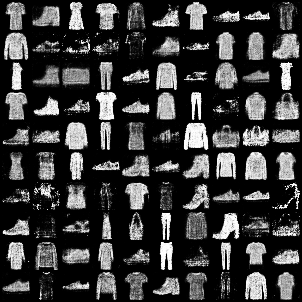

In [37]:
Image('./samples/fake_images-0310.png')

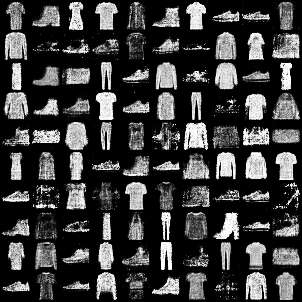

In [38]:
Image('./samples/fake_images-0400.png')

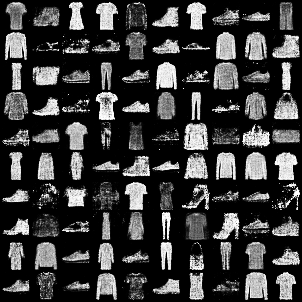

In [39]:
Image('./samples/fake_images-0600.png')

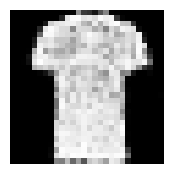

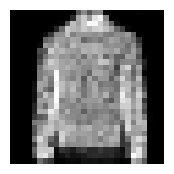

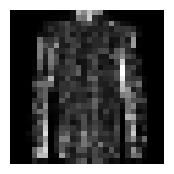

In [40]:
save_dir = 'new_generated_data/'
num_imgs = 3

os.makedirs(save_dir, exist_ok=True)

y = torch.randn(num_imgs, latent_size).to(device)
fake_images_new = G(y)
gen_imgs = denorm(fake_images_new.reshape((-1, 28,28)).detach())

for i in range(num_imgs):
    image_cpu = gen_imgs[i].cpu().numpy()
    plt.figure(figsize=(2, 2))
    plt.imshow(image_cpu, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.savefig(f'{save_dir}/generated_image_{i+1}.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()

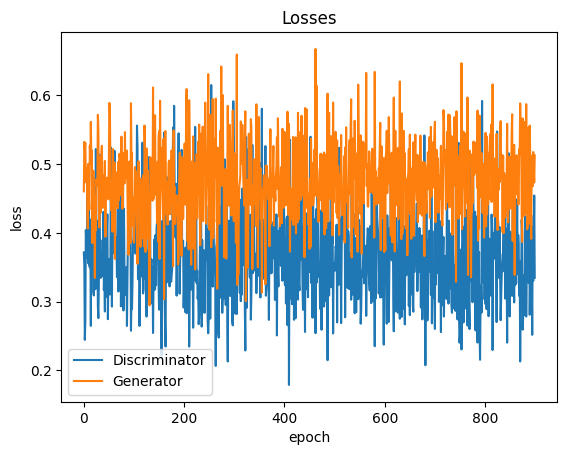

In [41]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

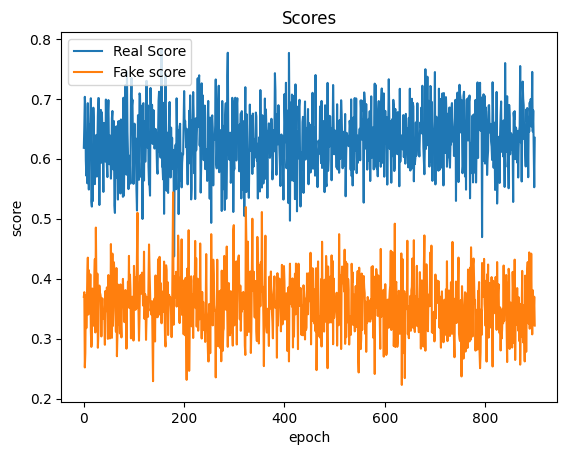

In [42]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### Step 7: Save the model weights without using checkpoints.

In [43]:
# Save the model weights
torch.save(G.state_dict(), 'G_retrain.ckpt')
torch.save(D.state_dict(), 'D_retrain.ckpt')

### Step 8: Load the model weights without using checkpoints.

In [44]:
G.load_state_dict(torch.load('G_retrain.ckpt'))
D.load_state_dict(torch.load('D_retrain.ckpt'))

<All keys matched successfully>

### Conclusion: LSGAN performed better than Regular GAN but with only slight change. Training time required for both was similar. 

### Github Link - https://github.com/daminivichare66/Deep_Learning_GANs